# IMDB Sentiment Analysis - XGBoost & SVM

In this lab, we will be revisiting the IMDB Movie Review Dataset for a more in-depth analysis and to test more complicated models. This dataset consists of 50K movie reviews that are labeled as positive or negative based on their sentiment toward a film. This week, we will focus on using SVM and XGBoost for the classification task. Similar to the first iteration with this task, this notebook will guide you through 4 main steps:

1. Text Preprocessing
2. Feature Engineering
3. Model Fitting
4. Hyper-Parameter Tuning

In [15]:
import os
import re

import pandas as pd
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from tqdm import tqdm
from scipy.stats import chi2_contingency
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 1. Text Preprocessing

The first step to this process will be loading the data. The data can be found [here](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download). Please download the data from this page which will produce a zip folder. Upon unzipping the folder, a file entitled "IMDB Dataset.csv" will be produced. Create a folder to hold data used in this course and place the "IMDB Dataset.csv" file in it. Next make sure that every package in the imports below is installed. The "nltk.download()" lines only need to be ran once. So comment them out with a # at the beginning of the line after the downloads have been completed.

In the following cell, set the **data_path** variable equal to the path of the "IMDB Dataset.csv" file.

In [16]:
data_path = r"C:\Users\GAUTHIER\Documents\Projects\DataMine\Data\IMDB_Dataset.csv"

### Normalization and Cleaning

In the next two cells, the data will be loaded, cleaned, and normalized. This will include:

1. Removing HTML chunks
2. Transforming text to lower case
3. Tokenizing text
4. Removing Stop Words and punctuation
5. Lemmatizing Words

In [17]:
data = pd.read_csv(data_path)
data.columns = ['text', 'label']
data['label'] = data.label.map({'negative': 0, 'positive': 1})

wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punct_remover = str.maketrans('', '', punctuation)

def preprocess_text(text):
    text = re.sub('<.*?>', '', text)
    tokens = wordpunct_tokenize(text.lower())
    tokens = [i.translate(punct_remover) for i in tokens]
    tokens = [i for i in tokens if i not in stop_words]
    tokens = [wnl.lemmatize(i) for i in tokens]
    text = " ".join(tokens)
    
    return text

In [18]:
text_data = []
for i in tqdm(data.text):
    text_data.append(preprocess_text(i))
data['text'] = text_data

avg_tokens = sum([len(i.split()) for i in data.text]) / len(data.text)
print(f"Average Number of Tokens per Review: {round(avg_tokens)}")

100%|██████████| 50000/50000 [00:25<00:00, 1935.08it/s]


Average Number of Tokens per Review: 120


## 2. Feature Engineering

In this step, we will work through generating a vector representation of each review in the corpus. There are two feature representations that we will be testing during this step: Bag-of-Words and TFIDF. For each review, the Bag-of-Words representation will generate a vector that is the size of the corpus vocabulary, where each element in the vector will correspond to the number of occurrences of a specific token in the review. To generate these representations, we will be using the CountVectorizer object from scikit-learn; the documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html?highlight=countvectorizer#sklearn.feature_extraction.text.CountVectorizer). On the other hand, the TFIDF method will also yield a vector equal to the size of the corpus vocabulary, but, instead of token counts, each element will correspond to the Term Frequency Inverse Document Frequency (TFIDF) of the specific token. This value is equal to the frequency of the term in the document multiplied by the inverse of how often the term occurs in all documents. The exact formula can be shown below:

$TDIDF(t, d) = TF(t, d) * \log{[\frac{n}{(DF(t) + 1)}]}$

In short, this metric gives a higher score for terms that are frequent in a document and then down scores terms that are common across all documents. To create this feature representation, we will be using the TfidfVectorizer object from scikit-learn; documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Similar to last week, there are a few variables that can be tuned here, using either Bag-of-Words or TFIDF:

* ngram_min - Minimum size of ngrams to use. Acceptable values are integers greater than or equal to 1
* ngram_max - Maximum size of ngrams to use. Acceptable values are integers greater than or equal to 1
* min_df - Minimum document frequency to be included in model. Acceptable values are integers greater than or equal to 1 to denote the raw count or float values in [0.0, 1.0] to denote percent frequency
* max_df - Minimum document frequency to be included in model. Same acceptable values as min_df

**Experiment:** Try different ngram ranges and frequency thresholds (min and max) for both the Bag-of-Words and TfIdf methods. Observe and note the changes in test performance, and model training time, as these parameters are changed.

### Feature Selection

To limit the complexity of the model, it may be good to only inlcude the terms that have the strongest relationship with the label. For this, we will look at how correlated each token is with the target variable. We can create two binary features: whether a token is present in a document and the document sentiment label. Matthews Correlation Coefficient can be used with these two features to determine how correlated the feature is with the label. The **get_correlated_features** function can be used to set a specific number of features which corresponds to the N most correlated features; the attribute in the function is called **num_features**. Be aware that the process of finding correlated features can be time consuming. Also, I **highly recommend using TFIDF features only**, as this method seems to converge better.

In [19]:
def get_correlated_matrix(text_data, labels, min_df=50, p_value=0.05, num_features=1000):
    # Get Document Term Matrix
    count_vector = CountVectorizer(ngram_range=(1, 1), min_df=50)
    ngram_counts = count_vector.fit_transform(text_data)
    doc_tokens = count_vector.inverse_transform(ngram_counts)

    # Map tokens to ids
    id2token = {i: j for i, j in enumerate(count_vector.get_feature_names())}
    token2id = {j: i for i, j in id2token.items()}
    doc_tokens = [set(token2id[j] for j in i) for i in doc_tokens]

    # Get the label for each token occurrence
    token_labels = []
    doc_id = 0
    for doc, label in zip(doc_tokens, labels):
        token_labels.extend([(i, label, doc_id) for i in doc])
        doc_id += 1
    token_labels = pd.DataFrame(token_labels)
    token_labels.columns = ["Token", "Label", "Document"]
    token_labels['Token_Present'] = 1
    doc_labels = {row.Document: row.Label for row in token_labels.itertuples()}

    # Calculate correlation to label for each token
    all_docs = token_labels.Document.unique()
    token2corr = Counter()
    for token_id in tqdm(id2token.keys()):
        all_token_docs = (
            pd.DataFrame({"Document": all_docs})
            .assign(Token=token_id)
            )
        token_id_labels = (
            token_labels[token_labels.Token == token_id]
            .merge(all_token_docs, on=['Token', 'Document'], how='outer')
            .assign(
                Token_Present = lambda df: df.Token_Present.fillna(0),
                Label = lambda df: df.Document.map(doc_labels))
            )
        # cont_table = token_id_labels.groupby(["Token_Present", "Label"]).size().unstack(fill_value=0).values
        # chi2, p, dof, ex = chi2_contingency(cont_table)
        # token2corr[token_id] = p
        token2corr[token_id] = matthews_corrcoef(token_id_labels.Label, token_id_labels.Token_Present)
    
    # Return Document-Term Matrix of correlated features
    # correlated_features = {k: v for k, v in token2corr.items() if v < 0.05}
    # correlated_tokens = sorted(correlated_features.keys())
    correlated_features = sorted(token2corr.items(), key=lambda x: abs(x[1]), reverse=True)
    print('Most Correlated Features')
    print('-' * 25)
    for i, j in correlated_features[:10]:
        print(id2token[i], j)
    correlated_tokens = [k for k, v in correlated_features[:num_features]]
    correlated_data = ngram_counts.T[correlated_tokens].T

    return correlated_data, count_vector, correlated_tokens

In [20]:
def generate_features(data, test_size=0.2, feature_type='bow', ngram_min=1, ngram_max=1, min_df=1, max_df=1.0):
    """
    Function to generate features for train and test data

    Parameters
    ----------
    data - Dataframe with columns 'text' and 'label'
    test_size - Proportion of data that will be held out for evaluation
    feature_type - Type of features to use as represenation. Options are 'bow' or 'tfidf'
    max_df - When building the vocabulary ignore terms that have a document frequency strictly
             higher than the given threshold (corpus-specific stop words). If float, the parameter
             represents a proportion of documents, integer absolute counts. This parameter is ignored
             if vocabulary is not None.
    min_df - When building the vocabulary ignore terms that have a document frequency strictly lower than
            the given threshold. If float, the parameter represents a proportion of documents, integer
            absolute counts. This parameter is ignored if vocabulary is not None.

    Returns
    -------
    x_train - Input features for the train set
    y_train - Labels for the train set
    x_test - Input features for the test set
    y_test - Labels for the test set
    """

    # Split data into Train and Test
    train_df, test_df = train_test_split(data, test_size=0.2)

    # Instantiate Object to generate feature representations
    if feature_type == 'bow':
        vectorizer = CountVectorizer(ngram_range=(ngram_min, ngram_max), min_df=min_df, max_df=max_df)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(ngram_range=(ngram_min, ngram_max), min_df=min_df, max_df=max_df)
    else:
        raise ValueError("feature_type must be set to either 'bow' or 'tfidf'.")
    
    # Generate features for train and test set
    x_train = vectorizer.fit_transform(train_df.text)
    x_test = vectorizer.transform(test_df.text)
    y_train = train_df.label.values
    y_test = test_df.label.values

    return x_train, y_train, x_test, y_test

In [21]:
def generate_correlated_features(data, test_size=0.2, num_features=1000, feature_type='bow', ngram_min=1, ngram_max=1, min_df=1, max_df=1.0):
    """
    Function to generate features for train and test data

    Parameters
    ----------
    data - Dataframe with columns 'text' and 'label'
    test_size - Proportion of data that will be held out for evaluation
    num_features - Number of features to include which will be the top N most correlated features
    feature_type - Type of features to use as represenation. Options are 'bow' or 'tfidf'
    max_df - When building the vocabulary ignore terms that have a document frequency strictly
             higher than the given threshold (corpus-specific stop words). If float, the parameter
             represents a proportion of documents, integer absolute counts. This parameter is ignored
             if vocabulary is not None.
    min_df - When building the vocabulary ignore terms that have a document frequency strictly lower than
            the given threshold. If float, the parameter represents a proportion of documents, integer
            absolute counts. This parameter is ignored if vocabulary is not None.

    Returns
    -------
    x_train - Input features for the train set
    y_train - Labels for the train set
    x_test - Input features for the test set
    y_test - Labels for the test set
    """
    
    # Check feature type for validity
    if feature_type not in ['bow', 'tfidf']:
        raise ValueError("feature_type must be set to either 'bow' or 'tfidf'.")

    # Split data into Train and Test
    train_df, test_df = train_test_split(data, test_size=0.2)

    # Get correlated features from the training set
    x_train, count_vectorizer, correlated_tokens = get_correlated_matrix(
        train_df.text.to_list(),
        train_df.label.to_list(),
        min_df=50
        )
    
    # Generate features for train and test set
    x_test = count_vectorizer.transform(test_df.text)
    x_test = x_test.T[correlated_tokens].T
    y_train = train_df.label.values
    y_test = test_df.label.values

    if feature_type == 'tfidf':
        tfidf = TfidfTransformer()
        x_train = tfidf.fit_transform(x_train)
        x_test = tfidf.transform(x_test)
    else:
        scaler = StandardScaler(with_mean=False)
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    return x_train, y_train, x_test, y_test

In [22]:
feature_type='tfidf'
ngram_min=1
ngram_max=2
min_df=50
max_df=1.0

In [23]:
x_train, y_train, x_test, y_test = generate_correlated_features(
    data, num_features = 500, feature_type=feature_type, ngram_min=ngram_min, ngram_max=ngram_max, min_df=min_df, max_df=max_df
    )

100%|██████████| 7877/7877 [05:30<00:00, 23.83it/s]


Most Correlated Features
-------------------------
bad -0.2761095830942107
worst -0.2541196374726938
great 0.20152241046793526
waste -0.1994667002886294
awful -0.1988023129332317
terrible -0.16940731605489462
excellent 0.16927606444658036
stupid -0.1575772528473143
boring -0.15561216730852787
wonderful 0.14970237474218126


## 3. Model Fitting

In this section we will be working on fitting two different models for the Sentiment Analysis task: Support Vector Machine (SVM) and Random Forest. First, I will provide code to train the models, as well as produce evaluation metrics and a confusion matrix. Note that for the confusion matrix, we want to maximize the True Negative (top left) and True Positive (bottom right) for our models. Then, I will present a challenge for the groups to work through.

### SVM

The support vector machine is a commonly used model that creates a decision boundary between between data points of different classes. Below are a few videos to get a general idea of how Support Vector Machines work:

1. Support Vector Machine in 2 minutes: [link](https://www.youtube.com/watch?v=_YPScrckx28)
2. Support Vector Machines Part 1 (of 3) - Main Ideas: [link](https://www.youtube.com/watch?v=efR1C6CvhmE)

To train this model, we will be using the SVC (Support Vector Classifier) object from scikit-learn; documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Evaluation Metrics
------------------
Precision: 0.8697093817047006
Recall: 0.8943040513437626
F1: 0.8818352615445466



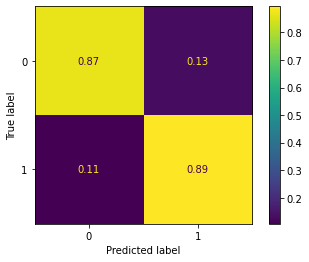

In [24]:
# Define model parameters and train model
svm_classifier = LinearSVC(penalty='l2', C=10, tol=1e-5, max_iter=10000)
svm_classifier.fit(x_train, y_train)

# Score Model
svm_score = svm_classifier.score(x_test, y_test)
test_pred = svm_classifier.predict(x_test)
test_prec = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)

print("Evaluation Metrics")
print('-' * 18)
print(f"Precision: {test_prec}")
print(f"Recall: {test_recall}")
print(f"F1: {test_f1}")
print()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, test_pred, normalize='true')
ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1]).plot()

### Random Forest

The next model that we will be using is the Random Forest. This algorithm is based on decision trees. Before testing with this model, please watch the two videos below to gain an understanding of how this algorithm works.

1. Decision Tree Classification Clearly Explained: [link](https://www.youtube.com/watch?v=ZVR2Way4nwQ)
2. Random Forest Algorithm Clearly Explained: [link](https://www.youtube.com/watch?v=v6VJ2RO66Ag)

To train this model, we will be using the RandomForestClassifier object from scikit-learn; documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random+forest#sklearn.ensemble.RandomForestClassifier)

Evaluation Metrics
------------------
Precision: 0.8450816407805655
Recall: 0.8511833132771761
F1: 0.8481215027977619



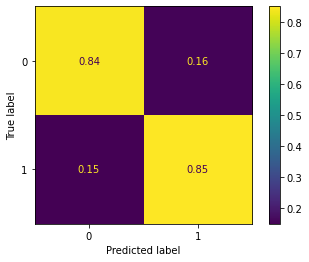

In [25]:
rf_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_classifier.fit(x_train, y_train)

# Score Model and Generate confusion matrix
svm_score = rf_classifier.score(x_test, y_test)
test_pred = rf_classifier.predict(x_test)
test_prec = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)
print("Evaluation Metrics")
print('-' * 18)
print(f"Precision: {test_prec}")
print(f"Recall: {test_recall}")
print(f"F1: {test_f1}")
print()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, test_pred, normalize='true')
ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1]).plot()

## Challenge

Now, you have seen how to train and evaluate the models, and are familiar with how grid search works from the previous weeks assignment. Extra documentation for sklearn's GridSearch Algorithm can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This week, you will need to develop your own grid search algorithm that finds two things:

1. Best feature type, number of features, ngram range, and minimum and maximum document frequencies. I suggest using the generate_features function that I have provided you. (note that ngram_min cannot be greater than ngram_max). Also get_correlated_features can be used for filtering based on correlation but this step can be slow. **ONLY USE TFIDF!!!**
2. The best set of hyper-parameters for the model. Once again, the hyper-parameters that can be used for both models can be found in the models' documentation: [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random+forest#sklearn.ensemble.RandomForestClassifier) and [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC).
3. **ONLY USE TFIDF!!!**. Bag-of-Words is not converging as well.

The goal of this grid search is to maximize F1, so you will need to provide the set of hyper-parameters that generates the best F1 along with it's confusion matrix for each model. Good Luck!